基于K-means的文本聚类
学号：3220221155
姓名：桂梦婷

一. 数据集统计和预处理
来源：https://blog.csdn.net/qq_36047533/article/details/88360833
cnews数据集中包含已经分类的文本，格式是”类别 文本内容“。
首先下载数据，发现数据集内包含train-test，以及词汇表vocab，停用词表stopword。由于仅采用K-means方法做文本聚类，文本聚类实验中仅采用test部分。

首先统计文本内容（包括分类、文本长度），并转换为DataFrame形式。

In [34]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import jieba.analyse as analyse
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score, precision_score

bert_path = "bert-base-chinese"
test_path = r".\cnews\cnews.test.txt"
train_path = r".\cnews\cnews.train.txt"
stopword_path = r".\cnews\stopwords.txt"

In [5]:
cate_dic = {}
test_df = pd.DataFrame(columns=['ID','text','category'])
# 类别编号
cate_count = 0
test_text_count = 0
with open(test_path,"r",encoding="utf-8") as f:
    for line in f:
        c = line.strip("\n")
        content_list = c.split("	")
        if content_list[0] not in cate_dic:
            cate_dic[content_list[0]] = cate_count
            cate_count += 1
        t_dic = {"ID":test_text_count,"text":content_list[1],"category":content_list[0]}
        test_text_count += 1
        test_df = test_df.append(t_dic,ignore_index=True)


In [6]:
# 统计总条数
print("test数据集条数有：{}".format(len(test_df)))
print("类别数目及分布为：")
print(test_df["category"].value_counts())
print("平均文本长度为:")
df_len_text = test_df["text"].str.len()
print(df_len_text.describe())

test数据集条数有：10000
类别数目及分布为：
时政    1000
体育    1000
家居    1000
时尚    1000
娱乐    1000
教育    1000
房产    1000
财经    1000
科技    1000
游戏    1000
Name: category, dtype: int64
平均文本长度为:
count    10000.000000
mean       969.133500
std        927.031517
min         13.000000
25%        432.000000
50%        730.000000
75%       1170.250000
max      14720.000000
Name: text, dtype: float64


可以发现，文本类别是较平均的，每条文本长度是非常不均衡的，但是平均文本长度也有969个字符。因此，后续基于K-means的文本聚类也需要考虑到字数差异。

二. 数据预处理
需要将文本转化成向量形式，并将特征向量作为文本聚类的操作对象，实现聚类。
本实验采取了用tf-idf向量作为文本的表征方法。
首先对文本进行分词，分词采用jieba+官方分词表stopword.txt，去除非中文字符后分词，写入新的list中。

In [7]:
stopwords = ['__', '___', '____', '______', '______________________________']
with open(stopword_path,"r",encoding="utf-8") as f:
    for line in f:
        stopwords.append(line.strip("\n"))

def cut_word(str):
    line = re.sub(r'[a-zA-Z0-9]*','',str)
    wordlist = jieba.lcut(line,cut_all=False) # 提取单词
    return ' '.join([word for word in wordlist if word not in stopwords
                     and len(word)>1]) # 空格连接



new_text_list = []
word_list = list(test_df['text'].apply(cut_word))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\gui\AppData\Local\Temp\jieba.cache
Loading model cost 1.053 seconds.
Prefix dict has been built successfully.


In [8]:
print(len(word_list))

10000


分词结束后，形成TF-IDF特征向量，用以表示每个
首次使用时发现，使用官方停用表时，有很多非常不相关和重复的词语，如”--“等。于是对停用词表进行扩充。

In [9]:
vectorizer = TfidfVectorizer()
tfidf_vector = vectorizer.fit_transform(word_list)

# 打印特征词
# feature_names = vectorizer.get_feature_names()
# print("特征词列表：", feature_names)
#
# # 打印TF-IDF向量
# print("TF-IDF向量：", tfidf_vector.toarray())

对TF-IDF向量矩阵做文本聚类，k=10。

In [10]:
k = 10  # 设置聚类的簇数
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(tfidf_vector)

# 打印每个文档所属的簇 for i in range(len(clusters)):
#     print("文档 {} 属于簇 {}".format(i, clusters[i]))

三. 聚类可视化

(1) TF-IDF方法聚类可视化
由于掺上的向量为高维向量，若需要可视化，则需要先采用PCA等方法降维。由于tf-idf是稀疏向量，无法采用PCA降维，于是采用TSNE进行降维。

In [11]:
from sklearn.manifold import TSNE

# 创建t-SNE对象
n_components = 2  # 设置降维后的维度
tsne = TSNE(n_components=n_components)
tsne_matrix = tsne.fit_transform(tfidf_vector)
print("降维后的矩阵形状：", tsne_matrix.shape)
print("降维后的矩阵：", tsne_matrix)

F:\Python\Python38\Lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
F:\Python\Python38\Lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


降维后的矩阵形状： (10000, 2)
降维后的矩阵： [[ 12.044805  56.30608 ]
 [ 18.702742  86.15227 ]
 [ 41.847183  56.590393]
 ...
 [-72.206665 -27.501408]
 [-41.942818 -44.415928]
 [-62.256092 -57.689884]]


In [12]:
# 类别可视化（预测类别）
colors = {"0":"#FA8072",
          "1":"#FFD700",
          "2":"#7CFC00",
          "3":"#00FFFF",
          "4":"#EE82EE",
          "5":"#FF69B4",
          "6":"#CD853F",
          "7":"#FA8072",
          "8":"#BC8F8F",
          "9":"#2F4F4F"}

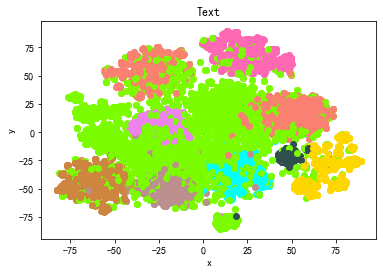

In [13]:
fig, ax = plt.subplots()
count = 0
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False
# 遍历每个点，并根据分类绘制不同颜色的散点图
for axis in tsne_matrix:
    x = axis[0]
    y = axis[1]
    ax.scatter(x, y, c=colors[str(clusters[count])])
    count += 1

ax.set_title('Text')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

四. 聚类效果分析
由于test本身具有标签，因此可以判断两种方法分类的准确性。将分类结果按照”少数服从多数“的原则映射到对应的类上，比如分类结果都是0的文本，如果其中归属于体育的文本多，则该类代表体育。

In [14]:
tfidf_cls_res = [[0 for j in range(10)] for i in range(10)]
for res_id in range(len(clusters)):
    tfidf_cls_res[clusters[res_id]][cate_dic[test_df.iloc[res_id]["category"]]] += 1
print(tfidf_cls_res)

[[0, 0, 0, 0, 0, 0, 1, 746, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 734, 0], [92, 1000, 360, 399, 432, 240, 981, 254, 88, 141], [0, 0, 622, 4, 2, 2, 0, 0, 1, 0], [0, 0, 0, 0, 560, 0, 3, 0, 0, 0], [908, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 0, 0, 845], [0, 0, 1, 0, 0, 758, 0, 0, 0, 0], [0, 0, 7, 597, 6, 0, 13, 0, 0, 14], [0, 0, 10, 0, 0, 0, 0, 0, 176, 0]]


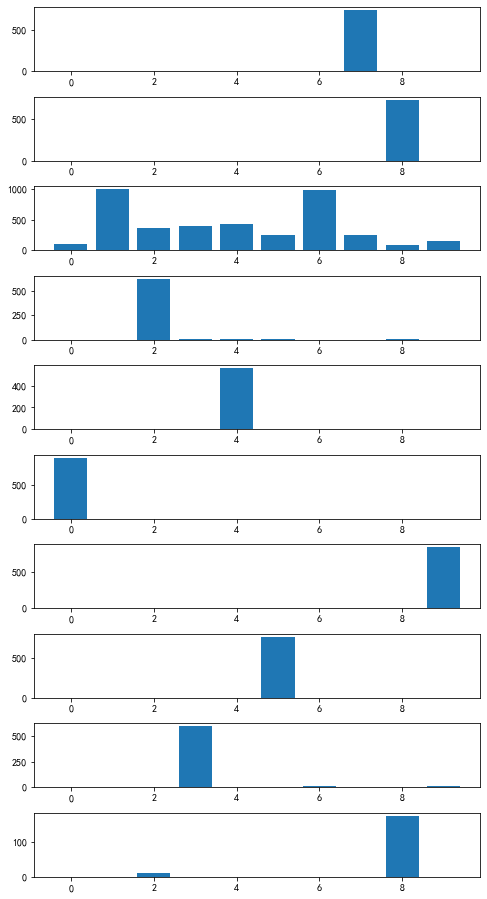

In [15]:
fig, axs = plt.subplots(10, 1, figsize=(8, 16))
for i in range(10):
    axs[i].bar(range(10), tfidf_cls_res[i])
plt.subplots_adjust(hspace=0.4)
plt.show()

从图中我们能够得到类的对应关系，可以计算精确率、召回率、F1值等。

In [62]:
pred_to_real = {}
for i in range(10):
    pred_to_real[i] = tfidf_cls_res[i].index(max(tfidf_cls_res[i]))
print(pred_to_real)

new_cluster = []
real_label = []
for res_id in range(len(clusters)):
    new_cluster.append(pred_to_real[clusters[res_id]])
    real_label.append(cate_dic[test_df.iloc[res_id]["category"]])

{0: 7, 1: 8, 2: 1, 3: 2, 4: 4, 5: 0, 6: 9, 7: 5, 8: 3, 9: 8}


In [63]:
all_recall = recall_score(real_label, new_cluster, average='macro')
all_accuracy = precision_score(real_label, new_cluster, average='macro')
class_recall = recall_score(real_label, new_cluster, average=None)
class_accuracy = precision_score(real_label, new_cluster, average=None)
print("全局准确率:", all_accuracy)
print("全局召回率:", all_recall)
print("每个类别的准确率:", class_accuracy)
print("每个类别的召回率:", class_recall)

全局准确率: 0.8151206969284557
全局召回率: 0.6946
每个类别的准确率: [1.         0.25081515 0.98573693 0.93720565 0.9946714  0.99868248
 0.         0.9973262  0.98913043 0.99763872]
每个类别的召回率: [0.908 1.    0.622 0.597 0.56  0.758 0.    0.746 0.91  0.845]


F:\Python\Python38\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Python38\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


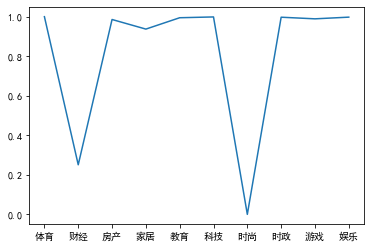

In [64]:
y = class_accuracy
x = ["体育","财经","房产","家居","教育","科技","时尚","时政","游戏","娱乐"]
plt.plot(x,y)
plt.show()

可以看到，分类效果有些情况下不太好，在前面我们也看到了，分词效果并不理想，“一万”、“一万三”等词义相似（且几乎没有用）的词也算在了tf-idf向量内，既增加了向量大小，又增加了无效的内容。因此，需要对每个文档的词范围进行约束。采用停用词并不准确，因此尝试采用文档TF-IDF值最高的前10个词作为文档表示。

In [55]:
# 基于jieba，从wordlist中提取top 10个关键词，作为该文档的表示
wordlist_10 = []
for text in test_df["text"]:
    seg_list = jieba.cut(text, cut_all=True)
    keywords = analyse.extract_tags(text, topK=10, withWeight=True, allowPOS=('n','nr','ns'))
    keyword_n = [i[0] for i in keywords]
    wordlist_10.append(" ".join(keyword_n))
tfidf_vector_10 = vectorizer.fit_transform(wordlist_10)

KeyboardInterrupt: 

In [39]:
k = 10  # 设置聚类的簇数
kmeans = KMeans(n_clusters=k)
clusters_10 = kmeans.fit_predict(tfidf_vector_10)

In [67]:
tfidf_cls_res_10 = [[0 for j in range(10)] for i in range(10)]
for res_id in range(len(clusters_10)):
    tfidf_cls_res_10[clusters_10[res_id]][cate_dic[test_df.iloc[res_id]["category"]]] += 1
print(tfidf_cls_res_10)

[[172, 988, 487, 555, 604, 185, 983, 328, 237, 110], [0, 0, 0, 0, 0, 0, 0, 0, 201, 0], [0, 10, 26, 8, 0, 811, 0, 5, 31, 0], [1, 2, 0, 0, 394, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 667, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 890], [0, 0, 0, 0, 0, 0, 0, 0, 523, 0], [827, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 432, 2, 0, 6, 0, 0, 0], [0, 0, 485, 5, 0, 4, 1, 0, 8, 0]]


In [41]:
pred_to_real = {}
for i in range(10):
    pred_to_real[i] = tfidf_cls_res_10[i].index(max(tfidf_cls_res_10[i]))
print(pred_to_real)

new_cluster_10 = []
real_label_10 = []
for res_id in range(len(clusters)):
    new_cluster_10.append(pred_to_real[clusters_10[res_id]])
    real_label_10.append(cate_dic[test_df.iloc[res_id]["category"]])

{0: 1, 1: 8, 2: 5, 3: 4, 4: 7, 5: 9, 6: 8, 7: 0, 8: 3, 9: 2}


In [69]:
n_components = 2  # 设置降维后的维度
tsne = TSNE(n_components=n_components)
tsne_matrix_10 = tsne.fit_transform(tfidf_vector_10)
print("降维后的矩阵形状：", tsne_matrix_10.shape)
print("降维后的矩阵：", tsne_matrix_10)

F:\Python\Python38\Lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
F:\Python\Python38\Lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


降维后的矩阵形状： (10000, 2)
降维后的矩阵： [[ 46.82212     4.79231  ]
 [ 76.5836      9.279406 ]
 [ 64.72158   -13.084511 ]
 ...
 [  7.137508  -64.03963  ]
 [ -7.3605537 -54.437218 ]
 [ -7.71123   -79.70779  ]]


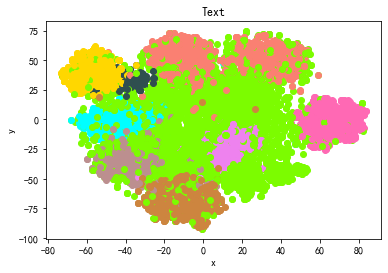

In [70]:
fig, ax = plt.subplots()
count = 0
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False
# 遍历每个点，并根据分类绘制不同颜色的散点图
for axis in tsne_matrix_10:
    x = axis[0]
    y = axis[1]
    ax.scatter(x, y, c=colors[str(clusters[count])])
    count += 1

ax.set_title('Text')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [56]:
all_recall_10 = recall_score(real_label_10, new_cluster_10, average='macro')
all_accuracy_10 = precision_score(real_label_10, new_cluster_10, average='macro')
class_recall_10 = recall_score(real_label_10, new_cluster_10, average=None)
class_accuracy_10 = precision_score(real_label_10, new_cluster_10, average=None)
print("全局准确率:", all_accuracy_10)
print("全局召回率:", all_recall_10)
print("每个类别的准确率:", class_accuracy_10)
print("每个类别的召回率:", class_recall_10)

全局准确率: 0.8032381310197909
全局召回率: 0.6218
每个类别的准确率: [1.         0.21251882 0.96421471 0.97737557 0.96805897 0.91021324
 0.         1.         1.         1.        ]
每个类别的召回率: [0.827 0.988 0.485 0.432 0.394 0.811 0.    0.667 0.724 0.89 ]


F:\Python\Python38\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Python\Python38\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


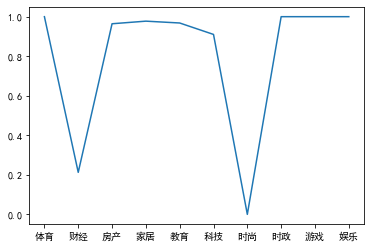

In [57]:
y = class_accuracy_10
x = ["体育","财经","房产","家居","教育","科技","时尚","时政","游戏","娱乐"]
plt.plot(x,y)
plt.show()

四. 结果分析
  可以看到，仅抽取关键词后，效果较之前有一些退步，但是类别准确率分布较先前好了很多。可以看到，有2种分类分类效果非常差，分别是财经、时尚（时尚分类甚至是0）。
  （1）财经新闻
  猜测财经新闻可能包含较多的数值，包括汉字数值、小数、百分比等等，这些数字可能由于分词的影响受到错误的切分，产生了不同的含义。在选取TOP10关键词后，该结果反而又下降了10个百分点，可能说明数字确实是财经新闻的重要组成部分之一，不应该简单的舍弃。
  （2）时尚新闻
  时尚新闻的分类效果最差，追溯到聚类效果，可以看到有一类文本经过降维显示，也并未具有较明显的聚集特征，这一类便是时尚类。观察了时尚类文本后，发现时尚文本有较为明显的跨领域性，比如阐述某明星参加电影上映会，再描述衣着，可能会被误以为是娱乐新闻。此外，在关键词提取后，娱乐新闻的分布更加分散，说明仅靠关键词并不能说明时尚文本阐述偏向，说明文本语义对文本聚类效果是较为重要的。